In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.metrics import log_loss
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
import xgboost as xgb

C:\Users\prane\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# reading the preprocessed dataset and droping the null values

df = pd.read_csv("preprocessed1.csv")
df = df.dropna()
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Time,is positive,reviews,HelpfulnessRatio
0,1,1,1303862400,1,good qualiti dog food good qualiti dog food go...,0.999990
1,0,0,1346976000,0,advertis advertis advertis product arriv label...,0.000000
2,1,1,1219017600,1,delight say delight say delight say confect ar...,0.999990
3,3,3,1307923200,0,cough medicin cough medicin cough medicin look...,0.999997
4,0,0,1350777600,1,great taffi great taffi great taffi great taff...,0.000000


In [3]:
# sorting the dataset in the ascending order of time

df = df.sort_values(by='Time', ascending = True)
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Time,is positive,reviews,HelpfulnessRatio
118098,0,0,939340800,1,everi book educ everi book educ everi book edu...,0.000000
118075,2,2,940809600,1,whole seri great way spend time child whole se...,0.999995
299630,0,0,944092800,1,entertainingl funni entertainingl funni entert...,0.000000
169589,1,2,944438400,1,modern day fairi tale modern day fairi tale mo...,0.499998
299629,0,0,946857600,1,fantast fantast fantast beetlejuic excel funni...,0.000000


In [4]:
# dropping the time column

df = df.drop(columns = ["Time"])
df.head()

,HelpfulnessNumerator,HelpfulnessDenominator,is positive,reviews,HelpfulnessRatio
118098,0,0,1,everi book educ everi book educ everi book edu...,0.000000
118075,2,2,1,whole seri great way spend time child whole se...,0.999995
299630,0,0,1,entertainingl funni entertainingl funni entert...,0.000000
169589,1,2,1,modern day fairi tale modern day fairi tale mo...,0.499998
299629,0,0,1,fantast fantast fantast beetlejuic excel funni...,0.000000


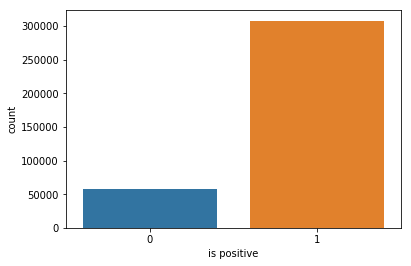

In [5]:
# distribution of is positive feature

sns.countplot(x = "is positive", data = df)

In [6]:
# dropping useless features and storing the dataframe alues in arrays

y = df["is positive"].values
df = df.drop(columns = ["is positive","HelpfulnessNumerator","HelpfulnessDenominator","HelpfulnessRatio"])
x = df.values

In [7]:
# shap of label array

y.shape

(365317,)

In [8]:
# shape of reviews array

x.shape

(365317, 1)

In [9]:
# performing temporal split on the data

x_train = x[0:233802,:]
x_cv = x[233802:292253,:]
x_test = x[292253:,:]

y_train = y[0:233802]
y_cv = y[233802:292253]
y_test = y[292253:]

In [10]:
# converting the resultant arrays in dataframes

df_train = pd.DataFrame(x_train)
df_train.columns = ["reviews"]
df_cv = pd.DataFrame(x_cv)
df_cv.columns = ["reviews"]
df_test = pd.DataFrame(x_test)
df_test.columns = ["reviews"]

In [11]:
# converting arrays to list

review_train = list(x_train[:,0])
review_cv = list(x_cv[:,0])
review_test = list(x_test[:,0])

In [12]:
# generating tfidf arrays

tfidf = TfidfVectorizer(lowercase=False, )
tfidf_train = tfidf.fit_transform(review_train)
tfidf_cv = tfidf.transform(review_cv)
tfidf_test = tfidf.transform(review_test)

In [13]:
# shape of traning, validation and test data

print("traning data shape:",tfidf_train.shape)
print("CV data shape:",tfidf_cv.shape)
print("test data shape:",tfidf_test.shape)

traning data shape: (233802, 60359)
CV data shape: (58451, 60359)
test data shape: (73064, 60359)


# Random model

In [14]:
y_pred_cv = np.zeros([58451,2])
for i in range(58451):
    x = np.random.rand(1,2)
    x = x/x.sum()
    y_pred_cv[i,:] = x

In [15]:
print("log loss of test data is:",log_loss(y_cv,y_pred_cv))

log loss of test data is: 0.8908029831354357


In [16]:
y_pred_test = np.zeros([73064,2])
for i in range(73064):
    x = np.random.rand(1,2)
    x = x/x.sum()
    y_pred_test[i,:] = x

In [17]:
print("log loss of test data is:",log_loss(y_test,y_pred_test))

log loss of test data is: 0.8794192441205901


# Logistic regression

In [18]:
alpha = [10 ** x for x in range(-5, 4)]

errors = []

for i in alpha:
    lr = LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    lr.fit(tfidf_train,y_train)
    
    clf = CalibratedClassifierCV(lr, method="sigmoid")
    clf.fit(tfidf_train, y_train)
    
    y_pred_cv = clf.predict_proba(tfidf_cv)
    
    errors.append(log_loss(y_cv, y_pred_cv, labels=lr.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, y_pred_cv, labels=lr.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.2390210948013578
For values of alpha =  0.0001 The log loss is: 0.2381979685744256
For values of alpha =  0.001 The log loss is: 0.23150593666864067
For values of alpha =  0.01 The log loss is: 0.208223170288464
For values of alpha =  0.1 The log loss is: 0.1809764624436315
For values of alpha =  1 The log loss is: 0.16715460638097548
For values of alpha =  10 The log loss is: 0.1687274191115216
For values of alpha =  100 The log loss is: 0.183286347383861
For values of alpha =  1000 The log loss is: 0.2054880238561125


In [19]:
lr = LogisticRegression(penalty='l2',C=1,class_weight='balanced')
lr.fit(tfidf_train,y_train)

clf = CalibratedClassifierCV(lr, method="sigmoid")
clf.fit(tfidf_train, y_train)

y_pred_cv = clf.predict_proba(tfidf_cv)

y_pred_test = clf.predict_proba(tfidf_test)

print("The cross validation loss:",log_loss(y_cv, y_pred_cv, labels=lr.classes_, eps=1e-15))
print("The test loss:",log_loss(y_test, y_pred_test, labels=lr.classes_, eps=1e-15))

The cross validation loss: 0.16715460638097548
The test loss: 0.16583083319771583


# Linear SVM

In [20]:
alpha = [10 ** x for x in range(-5, 5)]

errors = []

for i in alpha:
    lrsvm = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    lrsvm.fit(tfidf_train, y_train)
    
    cc = CalibratedClassifierCV(lrsvm, method="sigmoid")
    cc.fit(tfidf_train, y_train)
    
    y_pred_cv = cc.predict_proba(tfidf_cv)
    
    errors.append(log_loss(y_cv, y_pred_cv, labels = lrsvm.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, y_pred_cv, labels = lrsvm.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.16748635140087043
For values of alpha =  0.0001 The log loss is: 0.20066236347369112
For values of alpha =  0.001 The log loss is: 0.4117883266754433
For values of alpha =  0.01 The log loss is: 0.4727935420420394
For values of alpha =  0.1 The log loss is: 0.4727935420412047
For values of alpha =  1 The log loss is: 0.47279354203957885
For values of alpha =  10 The log loss is: 0.4727935420395626
For values of alpha =  100 The log loss is: 0.4727935420395625
For values of alpha =  1000 The log loss is: 0.47279354203956225
For values of alpha =  10000 The log loss is: 0.4727935420395625


In [21]:
lrsvm = SGDClassifier(alpha=0.00001, penalty='l1', loss='hinge', random_state=42)
lrsvm.fit(tfidf_train, y_train)

cc = CalibratedClassifierCV(lrsvm, method="sigmoid")
cc.fit(tfidf_train, y_train)

y_pred_cv = cc.predict_proba(tfidf_cv)

y_pred_test = cc.predict_proba(tfidf_test)

print("log loss on cross validation data:",log_loss(y_cv, y_pred_cv, labels = lrsvm.classes_, eps=1e-15))

print("log loss on test data:",log_loss(y_test, y_pred_test, labels = lrsvm.classes_, eps=1e-15))

log loss on cross validation data: 0.16748635140087043
log loss on test data: 0.16631841072691603
